# Overview

- nb08, nb09, nb10, nb11, nb14 のアンサンブル。

In [1]:
# Directories
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/malignant-comment-classification/train.csv
/kaggle/input/malignant-comment-classification/test.csv
/kaggle/input/wikipedia-toxicity/train.csv
/kaggle/input/jigsaw-toxic-severity-rating/sample_submission.csv
/kaggle/input/jigsaw-toxic-severity-rating/validation_data.csv
/kaggle/input/jigsaw-toxic-severity-rating/comments_to_score.csv
/kaggle/input/toxic-tweets-dataset/FinalBalancedDataset.csv
/kaggle/input/all-in-one-dataset/__results__.html
/kaggle/input/all-in-one-dataset/__resultx__.html
/kaggle/input/all-in-one-dataset/__notebook__.ipynb
/kaggle/input/all-in-one-dataset/all_in_one_jigsaw.csv
/kaggle/input/all-in-one-dataset/__output__.json
/kaggle/input/all-in-one-dataset/custom.css
/kaggle/input/toxic-bert/config.json
/kaggle/input/toxic-bert/README.md
/kaggle/input/toxic-bert/tokenizer_config.json
/kaggle/input/toxic-bert/pytorch_model.bin
/kaggle/input/toxic-bert/special_tokens_map.json
/kaggle/input/toxic-bert/vocab.txt
/kaggle/input/toxic-bert/flax_model.msgpack


In [2]:
# Parameters
DEBUG_FLAG = False
VERSION = 'nb15'

SUBMISSION_PATH = '/kaggle/input/jigsaw-toxic-severity-rating/sample_submission.csv'
VALIDATION_DATA_PATH = '/kaggle/input/jigsaw-toxic-severity-rating/validation_data.csv'
COMMENTS_SCORE_PATH = '/kaggle/input/jigsaw-toxic-severity-rating/comments_to_score.csv'

WIKI_TRAIN_PATH = '/kaggle/input/wikipedia-toxicity/train.csv'
TWEETS_TRAIN_PATH = '/kaggle/input/toxic-tweets-dataset/FinalBalancedDataset.csv'
MALIGNANT_TRAIN_PATH = '/kaggle/input/malignant-comment-classification/train.csv'
ALLINONE_TRAIN_PATH = '/kaggle/input/all-in-one-dataset/all_in_one_jigsaw.csv'

TOXIC_BERT_PATH = '/kaggle/input/toxic-bert'

N_SPLITS = 5 if not DEBUG_FLAG else 2

In [3]:
# Modules
import re
import sys
import time

import datatable as dt
import nltk
import numpy as np
import pandas as pd
import torch

from matplotlib import pyplot as plt
from matplotlib_venn import venn3
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, SGDClassifier, SGDRegressor
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import minmax_scale
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification


sys.setrecursionlimit(5000)

In [4]:
# My functions
def read_df(train_path):    
    valid = dt.fread(VALIDATION_DATA_PATH).to_pandas()
    test = dt.fread(COMMENTS_SCORE_PATH).to_pandas()
    submission = dt.fread(SUBMISSION_PATH).to_pandas()
    train = dt.fread(train_path).to_pandas()

    if DEBUG_FLAG:
        valid = valid.sample(n=1000).reset_index(drop=True)
        test = test.sample(n=1000).reset_index(drop=True)
        submission = submission.sample(n=1000).reset_index(drop=True)
        train = train.sample(n=1000).reset_index(drop=True)

    return valid, test, submission, train


# クリーニング関数
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None, whitelist=None):
    # clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    
    # remove numbers
    text = re.sub(r'[\d]', '', text)
            
    # Tokenize (convert from string to list)
    lst_text = text.split()
    
    # remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
                
    # Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    # Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
    
    # white words list
    if whitelist is not None:
        lst_text = [word for word in lst_text if word in whitelist]
        
    # back to string from list
    text = ' '.join(lst_text)
    
    return text


# adversarial validation
def adversarial_validation(train_X, train_y, tfidf):

    models = []
    oof_train = np.zeros((train_X.shape[0],))
    scores = []

    stkf = StratifiedKFold(
        n_splits=N_SPLITS, 
        shuffle=True,
        random_state=None
    )

    # 交差検証
    for fold_id, (train_idx, valid_idx) in enumerate(stkf.split(train_X, train_y)):
        start = time.time()
        print(f'* ' * 40)
        print(f'fold_id: {fold_id}')

        # 訓練データ、評価データ、テストデータを整形
        print(f'preprocessing ...')
        X_trn = train_X.iloc[train_idx].reset_index(drop=True)
        X_val = train_X.iloc[valid_idx].reset_index(drop=True)
        y_trn = train_y.iloc[train_idx].reset_index(drop=True)
        y_val = train_y.iloc[valid_idx].reset_index(drop=True)

        X_trn_tfidf = tfidf.transform(X_trn)
        X_val_tfidf = tfidf.transform(X_val)

        print('Total number of train samples:', X_trn_tfidf.shape[0])
        print('Total number of valid samples:', X_val_tfidf.shape[0])

        # 訓練
        print(f'training ...')
        clf = SGDClassifier(
            loss='log', 
            class_weight='balanced',
            max_iter=10000, 
            tol=1e-3, 
            n_jobs=-1
        )

        clf.fit(X_trn_tfidf, y_trn)

        # 推論
        print(f'predicting ...')
        val_pred = clf.predict_proba(X_val_tfidf)[:, 1]
        oof_train[valid_idx] = val_pred
        models.append(clf)

        # 評価
        print(f'validation ...')
        score_auc = roc_auc_score(y_val, val_pred)
        scores.append(score_auc)
        elapsed = time.time() - start
        print(f'fold {fold_id} - score: {score_auc:.6f}, elapsed time: {elapsed:.2f} [sec]')

    print(f'* ' * 40)
    print(f'Average AUC: {sum(scores)/N_SPLITS:.6f}')
    
    return oof_train, models


# main
def main_training(train_X, train_y, tfidf, predictor='clf'):

    models = []
    oof_train = np.zeros((train_X.shape[0],))
    scores = []

    kf = KFold(
        n_splits=N_SPLITS, 
        shuffle=True,
        random_state=None
    )

    # 交差検証
    for fold_id, (train_idx, valid_idx) in enumerate(kf.split(train_X, train_y)):
        start = time.time()
        print(f'* ' * 40)
        print(f'fold_id: {fold_id}')

        # 訓練データ、評価データ、テストデータを整形
        print(f'preprocessing ...')
        X_trn = train_X.iloc[train_idx].reset_index(drop=True)
        X_val = train_X.iloc[valid_idx].reset_index(drop=True)
        y_trn = train_y.iloc[train_idx].reset_index(drop=True)
        y_val = train_y.iloc[valid_idx].reset_index(drop=True)

        X_trn_tfidf = tfidf.transform(X_trn)
        X_val_tfidf = tfidf.transform(X_val)

        print('Total number of train samples:', X_trn_tfidf.shape[0])
        print('Total number of valid samples:', X_val_tfidf.shape[0])

        # 訓練
        print(f'training ...')
        if predictor == 'clf':
            clf = MultinomialNB()
            clf.fit(X_trn_tfidf, y_trn)

            # 推論
            print(f'predicting ...')
            val_pred = clf.predict_proba(X_val_tfidf)[:, 1]
            oof_train[valid_idx] = val_pred
            models.append(clf)
            
            print(f'validation ...')
            score = roc_auc_score(y_val, val_pred)
            
        elif predictor == 'reg':
            reg = Ridge(
                max_iter=10000, 
                tol=1e-3
            )
            reg.fit(X_trn_tfidf, y_trn)

            # 推論
            print(f'predicting ...')
            val_pred = reg.predict(X_val_tfidf)
            oof_train[valid_idx] = val_pred
            models.append(reg)
            
            print(f'validation ...')
            score = mean_squared_error(y_val, val_pred)

        scores.append(score)
        elapsed = time.time() - start
        
        print(f'fold {fold_id} - {predictor} score: {score:.6f}, elapsed time: {elapsed:.2f} [sec]')

    print(f'* ' * 40)
    if predictor == 'clf':
        print(f'Average AUC: {sum(scores)/N_SPLITS:.6f}')
    elif predictor == 'reg':
        print(f'Average MSE: {sum(scores)/N_SPLITS:.6f} Average RMSE: {np.sqrt(sum(scores)/N_SPLITS):.6f}')
    
    return oof_train, models

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
/kaggle/input/wikipedia-toxicity/train.csv
valid shape: (30108, 3)
test shape: (7537, 2)
submission shape: (7537, 2)
train.shape: (5000, 3)


,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...


,comment_id,text
0,114890,"""\n \n\nGjalexei, you asked about whether ther..."
1,732895,"Looks like be have an abuser , can you please ..."


,comment_id,score
0,114890,0.5
1,732895,0.5


,id,comment_text,toxic
0,e617e2489abe9bca,"""\r\n\r\n A barnstar for you! \r\n\r\n The De...",0
1,9250cf637294e09d,"""\r\n\r\nThis seems unbalanced. whatever I ha...",0


test_words size: 23636


,less_toxic,less_toxic_clean
0,This article sucks \n\nwoo woo wooooooo,articl suck woo woo wooooooo
1,"""And yes, people should recognize that but the...",ye peopl recogn usual dont object hear direct ...


,more_toxic,more_toxic_clean
0,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...,wher sexi pic gone main page
1,Daphne Guinness \n\nTop of the mornin' my fav...,daphn guin mornin favourit alien life form im ...


,text,text_clean
0,"""\n \n\nGjalexei, you asked about whether ther...",gjalexei ask antieditori polici call wikipedia...
1,"Looks like be have an abuser , can you please ...",look like abus look thank


,text,text_clean
0,"""\r\n\r\n A barnstar for you! \r\n\r\n The De...",barnstar defend wiki barnstar like edit page l...
1,"""\r\n\r\nThis seems unbalanced. whatever I ha...",unbalanc said mathsci said far extrem unpleas ...


1 / 7537
21 / 30108
21 / 30108
12 / 5000
advval_train_X shape: (12525,)
advval_train_y shape: (12525,)
feature extracting ...
Total number of features: 7982
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 0
preprocessing ...
Total number of train samples: 10020
Total number of valid samples: 2505
training ...
predicting ...
validation ...
fold 0 - score: 0.799153, elapsed time: 0.54 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 1
preprocessing ...
Total number of train samples: 10020
Total number of valid samples: 2505
training ...
predicting ...
validation ...
fold 1 - score: 0.805742, elapsed time: 0.63 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 2
preprocessing ...
Total number of train samples: 10020
Total number of valid samples: 2505
training ...
predicting ...
validation ...
fold 2 - score: 0.804407, elapsed time: 0.85 [sec]
* * * * * * 

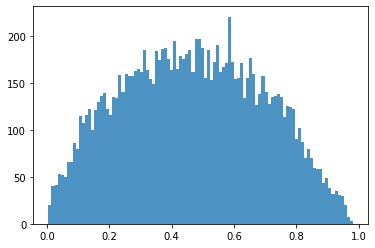

,oof_train,y
0,0.536042,1.0
1,0.322547,1.0
2,0.571308,1.0
3,0.517362,1.0
4,0.791520,1.0
...,...,...
7532,0.104405,0.0
7533,0.220961,0.0
7534,0.338829,0.0
7535,0.256518,0.0


1311
main_train_X shape: (12525,)
main_train_y shape: (12525,)
main_valid_less_X shape: (30108,)
main_valid_more_X shape: (30108,)
feature extracting ...
Total number of features: 1710
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 0
preprocessing ...
Total number of train samples: 1048
Total number of valid samples: 263
training ...
predicting ...
validation ...
fold 0 - clf score: 0.852408, elapsed time: 0.05 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 1
preprocessing ...
Total number of train samples: 1049
Total number of valid samples: 262
training ...
predicting ...
validation ...
fold 1 - clf score: 0.840681, elapsed time: 0.05 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 2
preprocessing ...
Total number of train samples: 1049
Total number of valid samples: 262
training ...
predicting ...
validation ...
fold 2 - clf score: 0.851475, ela

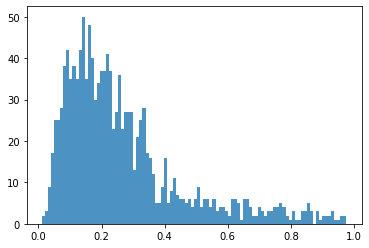

19006 / 30108
Local CV: 0.3181100705040514


,count,mean,std,min,25%,50%,75%,max
0,7537.0,0.5,0.0,0.5,0.5,0.5,0.5,0.5


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
/kaggle/input/toxic-tweets-dataset/FinalBalancedDataset.csv
valid shape: (30108, 3)
test shape: (7537, 2)
submission shape: (7537, 2)
train.shape: (56745, 3)


,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...


,comment_id,text
0,114890,"""\n \n\nGjalexei, you asked about whether ther..."
1,732895,"Looks like be have an abuser , can you please ..."


,comment_id,score
0,114890,0.5
1,732895,0.5


,C0,Toxicity,tweet,toxic
0,0,False,@user when a father is dysfunctional and is so...,0
1,1,False,@user @user thanks for #lyft credit i can't us...,0


test_words size: 23636


,less_toxic,less_toxic_clean
0,This article sucks \n\nwoo woo wooooooo,articl suck woo woo wooooooo
1,"""And yes, people should recognize that but the...",ye peopl recogn usual dont object hear direct ...


,more_toxic,more_toxic_clean
0,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...,wher sexi pic gone main page
1,Daphne Guinness \n\nTop of the mornin' my fav...,daphn guin mornin favourit alien life form im ...


,text,text_clean
0,"""\n \n\nGjalexei, you asked about whether ther...",gjalexei ask antieditori polici call wikipedia...
1,"Looks like be have an abuser , can you please ...",look like abus look thank


,text,text_clean
0,@user when a father is dysfunctional and is so...,user father dysfunct selfish drag kid dysfunct...
1,@user @user thanks for #lyft credit i can't us...,user user thank credit use caus dont offer van...


1 / 7537
21 / 30108
21 / 30108
263 / 56745
advval_train_X shape: (64019,)
advval_train_y shape: (64019,)
feature extracting ...
Total number of features: 9247
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 0
preprocessing ...
Total number of train samples: 51215
Total number of valid samples: 12804
training ...
predicting ...
validation ...
fold 0 - score: 0.978887, elapsed time: 1.08 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 1
preprocessing ...
Total number of train samples: 51215
Total number of valid samples: 12804
training ...
predicting ...
validation ...
fold 1 - score: 0.980134, elapsed time: 1.05 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 2
preprocessing ...
Total number of train samples: 51215
Total number of valid samples: 12804
training ...
predicting ...
validation ...
fold 2 - score: 0.976208, elapsed time: 1.06 [sec]
* * * *

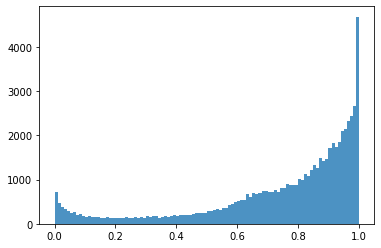

,oof_train,y
0,0.860924,1.0
1,0.918212,1.0
2,0.655802,1.0
3,0.945618,1.0
4,0.721494,1.0
...,...,...
7532,0.101135,0.0
7533,0.591899,0.0
7534,0.013569,0.0
7535,0.268964,0.0


3186
main_train_X shape: (64019,)
main_train_y shape: (64019,)
main_valid_less_X shape: (30108,)
main_valid_more_X shape: (30108,)
feature extracting ...
Total number of features: 1301
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 0
preprocessing ...
Total number of train samples: 2548
Total number of valid samples: 638
training ...
predicting ...
validation ...
fold 0 - clf score: 0.889661, elapsed time: 0.04 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 1
preprocessing ...
Total number of train samples: 2549
Total number of valid samples: 637
training ...
predicting ...
validation ...
fold 1 - clf score: 0.861025, elapsed time: 0.05 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 2
preprocessing ...
Total number of train samples: 2549
Total number of valid samples: 637
training ...
predicting ...
validation ...
fold 2 - clf score: 0.876146, ela

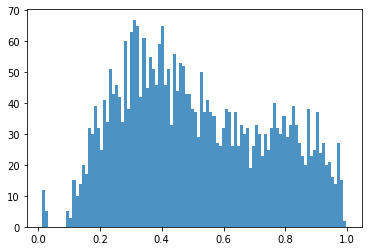

25311 / 30108
Local CV: 0.38086207577733


,count,mean,std,min,25%,50%,75%,max
0,7537.0,0.5,0.0,0.5,0.5,0.5,0.5,0.5


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
/kaggle/input/malignant-comment-classification/train.csv
valid shape: (30108, 3)
test shape: (7537, 2)
submission shape: (7537, 2)
train.shape: (159571, 8)


,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...


,comment_id,text
0,114890,"""\n \n\nGjalexei, you asked about whether ther..."
1,732895,"Looks like be have an abuser , can you please ..."


,comment_id,score
0,114890,0.5
1,732895,0.5


,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,False,False,False,False,False,False,0.0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,False,False,False,False,False,False,0.0


test_words size: 23636


,less_toxic,less_toxic_clean
0,This article sucks \n\nwoo woo wooooooo,articl suck woo woo wooooooo
1,"""And yes, people should recognize that but the...",ye peopl recogn usual dont object hear direct ...


,more_toxic,more_toxic_clean
0,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...,wher sexi pic gone main page
1,Daphne Guinness \n\nTop of the mornin' my fav...,daphn guin mornin favourit alien life form im ...


,text,text_clean
0,"""\n \n\nGjalexei, you asked about whether ther...",gjalexei ask antieditori polici call wikipedia...
1,"Looks like be have an abuser , can you please ...",look like abus look thank


,text,text_clean
0,Explanation\nWhy the edits made under my usern...,explan edit usernam hardcor fan revert werent ...
1,D'aww! He matches this background colour I'm s...,match background colour im seemingli stuck tha...


1 / 7537
21 / 30108
21 / 30108
503 / 159571
advval_train_X shape: (166605,)
advval_train_y shape: (166605,)
feature extracting ...
Total number of features: 18094
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 0
preprocessing ...
Total number of train samples: 133284
Total number of valid samples: 33321
training ...
predicting ...
validation ...
fold 0 - score: 0.807915, elapsed time: 7.25 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 1
preprocessing ...
Total number of train samples: 133284
Total number of valid samples: 33321
training ...
predicting ...
validation ...
fold 1 - score: 0.812853, elapsed time: 7.03 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 2
preprocessing ...
Total number of train samples: 133284
Total number of valid samples: 33321
training ...
predicting ...
validation ...
fold 2 - score: 0.815313, elapsed time: 7.37 [sec]


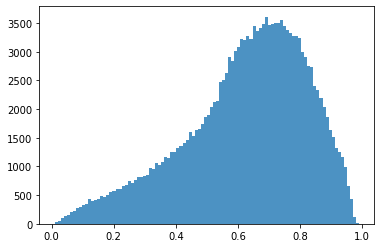

,oof_train,y
0,0.631623,1.0
1,0.835613,1.0
2,0.505305,1.0
3,0.905335,1.0
4,0.641244,1.0
...,...,...
7532,0.138565,0.0
7533,0.199261,0.0
7534,0.534753,0.0
7535,0.357349,0.0


34791
main_train_X shape: (166605,)
main_train_y shape: (166605,)
main_valid_less_X shape: (30108,)
main_valid_more_X shape: (30108,)
feature extracting ...
Total number of features: 11219
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 0
preprocessing ...
Total number of train samples: 27832
Total number of valid samples: 6959
training ...
predicting ...
validation ...
fold 0 - reg score: 0.015596, elapsed time: 1.26 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 1
preprocessing ...
Total number of train samples: 27833
Total number of valid samples: 6958
training ...
predicting ...
validation ...
fold 1 - reg score: 0.015907, elapsed time: 1.52 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 2
preprocessing ...
Total number of train samples: 27833
Total number of valid samples: 6958
training ...
predicting ...
validation ...
fold 2 - reg score: 0.0

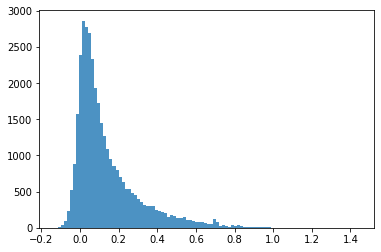

17351 / 30108
Local CV: 0.6993833208460607


,count,mean,std,min,25%,50%,75%,max
0,7537.0,0.5,0.0,0.5,0.5,0.5,0.5,0.5


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
/kaggle/input/all-in-one-dataset/all_in_one_jigsaw.csv
valid shape: (30108, 3)
test shape: (7537, 2)
submission shape: (7537, 2)
train.shape: (2223065, 11)


,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...


,comment_id,text
0,114890,"""\n \n\nGjalexei, you asked about whether ther..."
1,732895,"Looks like be have an abuser , can you please ..."


,comment_id,score
0,114890,0.5
1,732895,0.5


,C0,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,dataset,comment_text_processed
0,0,0000997932d777bf,0.0,0.0,0.0,0.0,0.0,0.0,toxic_comment,explanation why the edits made under my userna...
1,1,000103f0d9cfb60f,0.0,0.0,0.0,0.0,0.0,0.0,toxic_comment,d'aww he matches this background colour i'm se...


test_words size: 23636


,less_toxic,less_toxic_clean
0,This article sucks \n\nwoo woo wooooooo,articl suck woo woo wooooooo
1,"""And yes, people should recognize that but the...",ye peopl recogn usual dont object hear direct ...


,more_toxic,more_toxic_clean
0,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...,wher sexi pic gone main page
1,Daphne Guinness \n\nTop of the mornin' my fav...,daphn guin mornin favourit alien life form im ...


,text,text_clean
0,"""\n \n\nGjalexei, you asked about whether ther...",gjalexei ask antieditori polici call wikipedia...
1,"Looks like be have an abuser , can you please ...",look like abus look thank


,text,text_clean
0,explanation why the edits made under my userna...,explan edit usernam hardcor fan revert werent ...
1,d'aww he matches this background colour i'm se...,match background colour im seemingli stuck tha...


1 / 7537
21 / 30108
21 / 30108
10358 / 2223065
advval_train_X shape: (2220244,)
advval_train_y shape: (2220244,)
feature extracting ...
Total number of features: 17840
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 0
preprocessing ...
Total number of train samples: 1776195
Total number of valid samples: 444049
training ...
predicting ...
validation ...
fold 0 - score: 0.937906, elapsed time: 83.66 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 1
preprocessing ...
Total number of train samples: 1776195
Total number of valid samples: 444049
training ...
predicting ...
validation ...
fold 1 - score: 0.933940, elapsed time: 78.73 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 2
preprocessing ...
Total number of train samples: 1776195
Total number of valid samples: 444049
training ...
predicting ...
validation ...
fold 2 - score: 0.936260, elapsed time

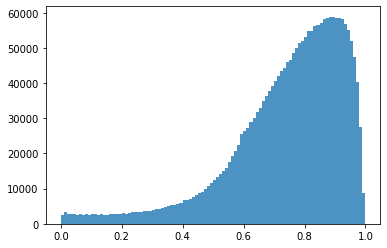

,oof_train,y
0,0.097769,1.0
1,0.428385,1.0
2,0.033822,1.0
3,0.503638,1.0
4,0.395778,1.0
...,...,...
7532,0.087574,0.0
7533,0.024416,0.0
7534,0.112922,0.0
7535,0.064690,0.0


217346
main_train_X shape: (2220244,)
main_train_y shape: (2220244,)
main_valid_less_X shape: (30108,)
main_valid_more_X shape: (30108,)
feature extracting ...
Total number of features: 14612
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 0
preprocessing ...
Total number of train samples: 173876
Total number of valid samples: 43470
training ...
predicting ...
validation ...
fold 0 - reg score: 0.006558, elapsed time: 7.71 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 1
preprocessing ...
Total number of train samples: 173877
Total number of valid samples: 43469
training ...
predicting ...
validation ...
fold 1 - reg score: 0.006523, elapsed time: 7.83 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 2
preprocessing ...
Total number of train samples: 173877
Total number of valid samples: 43469
training ...
predicting ...
validation ...
fold 2 - reg s

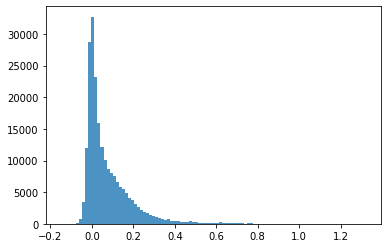

21863 / 30108
Local CV: 0.6926771257375475


,count,mean,std,min,25%,50%,75%,max
0,7537.0,0.5,0.0,0.5,0.5,0.5,0.5,0.5


In [5]:
train_paths = [WIKI_TRAIN_PATH, TWEETS_TRAIN_PATH, MALIGNANT_TRAIN_PATH, ALLINONE_TRAIN_PATH]
lst_preds_test = []

for train_path in train_paths:
    print('■'*80)
    print(train_path)
    
    valid, test, submission, train = read_df(train_path)

    print(f'valid shape: {valid.shape}')
    print(f'test shape: {test.shape}')
    print(f'submission shape: {submission.shape}')
    print(f'train.shape: {train.shape}')
    
    if train_path == WIKI_TRAIN_PATH:
        train['toxic'] = train['toxic'].astype(int)
        predictor = 'clf'
    elif train_path == TWEETS_TRAIN_PATH:
        train['toxic'] = train['Toxicity'].astype(int)
        predictor = 'clf'
    elif train_path == MALIGNANT_TRAIN_PATH:
        train['toxic'] = train[['malignant', 'highly_malignant', 'rude', 'threat', 'abuse', 'loathe']].sum(axis=1)
        train['toxic'] += train['highly_malignant']
        train['toxic'] /= train['toxic'].max()
        predictor = 'reg'
    elif train_path == ALLINONE_TRAIN_PATH:
        train = train.drop('comment_text', axis=1)
        train['toxic'] = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)
        train['toxic'] += train['severe_toxic']
        train['toxic'] /= train['toxic'].max()
        predictor = 'reg'
    
    display(valid.head(2))
    display(test.head(2))
    display(submission.head(2))
    display(train.head(2))
    
    # test のクリーニング
    stop_words = list(text.ENGLISH_STOP_WORDS)
    test['text_clean'] = test['text'].apply(lambda x: 
        utils_preprocess_text(x, flg_stemm=True, flg_lemm=True, lst_stopwords=stop_words, whitelist=None)
    )
    test_words = set(' '.join(test['text_clean']).split())
    print(f'test_words size: {len(test_words)}')
    
    # valid のクリーニング
    valid_unique_text = pd.Series(pd.concat([valid['less_toxic'], valid['more_toxic']]).unique())
    valid_unique_text_cleaned = valid_unique_text.apply(lambda x: 
        utils_preprocess_text(x, flg_stemm=True, flg_lemm=True, lst_stopwords=stop_words, whitelist=test_words)
    )
    valid_unique_text_dic = {text: cleaned_text for text, cleaned_text in zip(valid_unique_text, valid_unique_text_cleaned)}
    valid['less_toxic_clean'] = valid['less_toxic'].map(valid_unique_text_dic)
    valid['more_toxic_clean'] = valid['more_toxic'].map(valid_unique_text_dic)

    # train のクリーニング
    dic_rename = {'comment_text': 'text', 'tweet': 'text', 'comment_text_processed': 'text'}
    
    train = train.rename(columns=dic_rename)
    train['text_clean'] = train['text'].apply(lambda x: 
        utils_preprocess_text(x, flg_stemm=True, flg_lemm=True, lst_stopwords=stop_words, whitelist=test_words)
    )
    
    display(valid[['less_toxic', 'less_toxic_clean']].head(2))
    display(valid[['more_toxic', 'more_toxic_clean']].head(2))
    display(test[['text', 'text_clean']].head(2))
    display(train[['text', 'text_clean']].head(2))
    
    # クリーニングにより空文字列になった文字列を抽出
    print(sum(test['text_clean'].apply(lambda x: len(x)) == 0), '/', len(test))
    print(sum(valid['less_toxic_clean'].apply(lambda x: len(x)) == 0), '/', len(valid))
    print(sum(valid['more_toxic_clean'].apply(lambda x: len(x)) == 0), '/', len(valid))
    print(sum(train['text_clean'].apply(lambda x: len(x)) == 0), '/', len(train))
    
    # 空文字列の行を除く
    valid['less_toxic_size'] = valid['less_toxic_clean'].apply(lambda x: len(x))
    valid['more_toxic_size'] = valid['more_toxic_clean'].apply(lambda x: len(x))
    valid = valid.query('less_toxic_size != 0 | more_toxic_size != 0')
    train['word_size'] = train['text_clean'].apply(lambda x: len(x))
    train = train.query('word_size != 0')
    
    # preparing adversarial validation
    advval_train_X = pd.concat([train['text_clean'], test['text_clean']])
    advval_train_y = pd.concat([pd.Series(np.ones(train.shape[0])), pd.Series(np.zeros(test.shape[0]))])
    advval_valid_less_X = valid['less_toxic_clean']
    advval_valid_more_X = valid['more_toxic_clean']

    print(f'advval_train_X shape: {advval_train_X.shape}')
    print(f'advval_train_y shape: {advval_train_y.shape}')
    
    # 特徴抽出
    print(f'feature extracting ...')
    advval_tfidf = TfidfVectorizer(
        stop_words=stop_words,
        min_df=3,
        max_df=0.5, 
        max_features=100_000,
        analyzer='word',
        ngram_range=(1, 1)
    )
    advval_train_X_tfidf = advval_tfidf.fit_transform(advval_train_X)
    advval_train_X_tfidf_feature_names = advval_tfidf.get_feature_names()
    advval_train_X_tfidf_vocab = advval_tfidf.vocabulary_
    advval_valid_less_X_tfidf = advval_tfidf.transform(advval_valid_less_X)
    advval_valid_more_X_tfidf = advval_tfidf.transform(advval_valid_more_X)

    print('Total number of features:', advval_train_X_tfidf.shape[1])
    
    advval_oof_train, advval_models = adversarial_validation(advval_train_X, advval_train_y, advval_tfidf)
    
    plt.figure()
    plt.hist(advval_oof_train, alpha=.8, bins=100)
    plt.show()
    
    advval_oof_train = pd.DataFrame({'oof_train': advval_oof_train, 'y': advval_train_y})
    display(advval_oof_train)
    
    # 訓練データのうちテストデータに近いサンプルを抽出
    advval_train_idx = advval_oof_train.query('oof_train < 0.5 & y == 1').index
    print(len(advval_train_idx))
    
    # preparing main training data
    main_train_X = train.iloc[advval_train_idx]['text_clean']
    main_train_y = train.iloc[advval_train_idx]['toxic']
    main_valid_less_X = valid['less_toxic_clean']
    main_valid_more_X = valid['more_toxic_clean']

    print(f'main_train_X shape: {advval_train_X.shape}')
    print(f'main_train_y shape: {advval_train_y.shape}')
    print(f'main_valid_less_X shape: {main_valid_less_X.shape}')
    print(f'main_valid_more_X shape: {main_valid_more_X.shape}')
    
    # 特徴抽出
    print(f'feature extracting ...')
    main_tfidf = TfidfVectorizer(
        stop_words=stop_words,
        min_df=3,
        max_df=0.5, 
        max_features=100_000,
        analyzer='word',
        ngram_range=(1, 1)
    )

    main_train_X_tfidf = main_tfidf.fit_transform(main_train_X)
    main_train_X_tfidf_feature_names = main_tfidf.get_feature_names()
    main_train_X_tfidf_vocab = main_tfidf.vocabulary_
    main_valid_less_X_tfidf = main_tfidf.transform(main_valid_less_X)
    main_valid_more_X_tfidf = main_tfidf.transform(main_valid_more_X)

    print('Total number of features:', main_train_X_tfidf.shape[1])
    
    main_oof_train, main_models = main_training(main_train_X, main_train_y, main_tfidf, predictor=predictor)
    
    # スコア分布
    plt.figure()
    plt.hist(main_oof_train, alpha=.8, bins=100)
    plt.show()
    
    # adversarial validation によりテストデータに近い評価データを作成
    advval_score_valid_less_toxic = np.array([clf.predict_proba(advval_valid_less_X_tfidf)[:, 1] for clf in advval_models]).sum(axis=0) / len(advval_models)
    advval_score_valid_more_toxic = np.array([clf.predict_proba(advval_valid_more_X_tfidf)[:, 1] for clf in advval_models]).sum(axis=0) / len(advval_models)

    test_like_valid_idx = (advval_score_valid_less_toxic < 0.5) & (advval_score_valid_more_toxic < 0.5)
    print(sum(test_like_valid_idx), '/', len(test_like_valid_idx))

    # validation score
    preds_less_toxic = np.array([reg.predict(main_valid_less_X_tfidf[test_like_valid_idx]) for reg in main_models]).sum(axis=0)
    preds_more_toxic = np.array([reg.predict(main_valid_more_X_tfidf[test_like_valid_idx]) for reg in main_models]).sum(axis=0)
    print(f'Local CV: {(preds_less_toxic < preds_more_toxic).mean()}')
    
    # prediction
    test_X_tfidf = main_tfidf.transform(test['text_clean'])
    if predictor == 'clf':
        preds_test = np.array([predictor.predict_proba(test_X_tfidf)[:, 1] for predictor in main_models]).sum(axis=0) / N_SPLITS
    elif predictor == 'reg':
        preds_test = np.array([predictor.predict(test_X_tfidf) for predictor in main_models]).sum(axis=0) / N_SPLITS
    lst_preds_test.append(preds_test)
    
    if not DEBUG_FLAG:
        display(pd.DataFrame(pd.Series(submission['score'].ravel()).describe()).transpose())

In [6]:
# BERT
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
tokenizer = AutoTokenizer.from_pretrained(TOXIC_BERT_PATH)
model = AutoModelForSequenceClassification.from_pretrained(TOXIC_BERT_PATH).to(device)
comments_to_score = dt.fread(COMMENTS_SCORE_PATH).to_pandas()

BS = 8
def get_comments_to_score():
    txts = comments_to_score['text'].values
    for i in range(0, len(txts), BS):
        yield txts[i : i + BS].tolist()
        

outputs = []
for sequences in tqdm(get_comments_to_score(), total = len(comments_to_score) // BS): 
    tokens = tokenizer(sequences, 
                       padding=True, 
                       truncation=True, 
                       add_special_tokens=True,
                       return_tensors='pt').to(device)
    output = model(**tokens)
    outputs.append(output['logits'].cpu().detach().numpy())
    
predictions = np.concatenate(outputs)[:,0]
comments_to_score['score'] = predictions
comments_to_score = comments_to_score.drop('text', axis = 1)
comments_to_score

  0%|          | 0/942 [00:00<?, ?it/s]

,comment_id,score
0,114890,-7.450975
1,732895,-5.634093
2,1139051,-5.636992
3,1434512,-6.059226
4,2084821,-0.620955
...,...,...
7532,504235362,0.007879
7533,504235566,-2.626713
7534,504308177,-5.280117
7535,504570375,4.360547


In [7]:
lst_preds_test.append(comments_to_score['score'])
lst_preds_test = [minmax_scale(preds_test) for preds_test in lst_preds_test]

In [8]:
preds_test = np.array(lst_preds_test).sum(axis=0)
submission['score'] = preds_test

submission.to_csv('submission.csv', index=False)
submission

,comment_id,score
0,114890,0.497002
1,732895,1.222029
2,1139051,0.890608
3,1434512,0.775656
4,2084821,1.475467
...,...,...
7532,504235362,1.319243
7533,504235566,1.101443
7534,504308177,0.630838
7535,504570375,2.370790
